https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search

In [1]:
import keras
import tensorflow as tf
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time

Using TensorFlow backend.


# Préparation des données

Nous chargeons le dataset du Fashion MNIST

In [57]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Nous avons 60k d'exemples dans le trainset, chacun de taille 28x28. Nous avons aussi les 60k étiquettes du trainset. Ici, les étuiquettes ne sont pas en format one hot nous allons donc les transformer. De plus, nous allons normaliser les entrés des images en les divisant par 255 soit la valeur maximale pour avoir un input entre 0 et 1. 

In [58]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


Nous avons 10k d'exemples dans le testset, chacun de taille 28x28.

Nous allons séparer le test set pour créer une validation set de taille égale.

In [59]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [60]:
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [61]:
print(x_validation.shape)
print(y_validation.shape)

(5000, 28, 28)
(5000,)


In [62]:
print(x_test.shape)
print(y_test.shape)

(5000, 28, 28)
(5000,)


On scale les images entre 0 et 1.

In [63]:
ohe = OneHotEncoder(categories="auto",sparse=False)
ohe.fit(y_train.reshape(-1, 1))
x_train, x_validation, x_test = x_train/255, x_validation/255, x_test/255
y_train, y_validation, y_test = ohe.transform(y_train.reshape(-1, 1)), ohe.transform(y_validation.reshape(-1, 1)), ohe.transform(y_test.reshape(-1, 1))
print(np.min(x_train))
print(np.max(x_train))
print(y_train.shape)

0.0
1.0
(60000, 10)


Nous avons bien 10 classes et nous avons scalé les features de images. Nous avons un ensemble de test, de validation et de test. Il ne reste plus que reshape les images pour notre réseau dense pour avoir une entrée de taille 28**2.

In [64]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]**2)
x_validation = x_validation.reshape(x_validation.shape[0],x_validation.shape[1]**2)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)

In [65]:
x_train = np.array(x_train,dtype=np.float32)
x_validation = np.array(x_validation,dtype=np.float32)
x_test = np.array(x_test,dtype=np.float32)

In [66]:
y_train = np.array(y_train,dtype=np.float32)
y_validation = np.array(y_validation,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)


Dans cette partie, nous explorerons un réseau de neuronnes de type Dense soit fully connected.

In [67]:
# code trouve sur internet trouver le lien

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Min Training loss (' + str(str(format(np.min(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmin(history.history[l]),'d')))))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Min Validation loss (' + str(str(format(np.min(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmin(history.history[l]),'d')))))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Max Training Acc (' + str(str(format(np.max(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmax(history.history[l]),'d')))))
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Max Validation Acc (' + str(str(format(np.max(history.history[l]),'.5f'))+') at epoch '+ str(str(format(np.argmax(history.history[l]),'d')))))

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [68]:
def create_model(hidden_layer_number=1, neurons=100, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0,l2=0):
    
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=28**2, kernel_initializer='uniform',
                    activation=activation, kernel_regularizer=l1_l2(l1,l2)))
    if dropout >0:
        model.add(Dropout(dropout)) 
    
    if batchnorm:
        model.add(BatchNormalization())

    if hidden_layer_number>1:
        for i in range(hidden_layer_number-1):
            model.add(Dense(neurons, kernel_initializer='uniform',
                            activation=activation, kernel_regularizer=l1_l2(l1,l2)))
            if dropout >0:
                model.add(Dropout(dropout))        

            if batchnorm:
                model.add(BatchNormalization())
    
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

### Paramètres essayés

In [69]:
# # define the grid search parameters
# batch_size = [256, 512, 1024]
# epochs = [100, 200, 300]
# hidden_layer_number = [1, 2, 3]
# neurons = [100, 200, 300]
# activations = ['sigmoid', 'relu']
# dropouts = [0, 0.2, 0.4]
# batchnorms = [False, True]
# # l1s = [0.0001, 0.01, 1, 100]
# # l2s = [0.0001, 0.01, 1, 100]
# optimizers = ['adam', 'Adadelta']
# total_length = len(batch_size)*len(epochs)*len(hidden_layer_number)*len(neurons)*len(activations)*len(dropouts)*len(batchnorms)*len(optimizers)
# print(total_length)
lr_reducer = ReduceLROnPlateau(factor=0.7,
                               cooldown=0,
                               patience=10,
                               min_lr=0.5e-6)
callbacks = [EarlyStopping(monitor='val_loss', patience=50), lr_reducer]

Nous allons fixer les seeds pour avoir des expériences reproductibles

In [70]:
best = 1000000

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Partie DENSE

##### Nous allons trouver le bons nombre de parametre #####

Nous allons commencer avec un simple réseau avec un minibatch_size de 2048, une couche caché de 1500 neurones, un optimizer Adam et des fonctiosn d'activation relu. De cette manière il sera possible d'essayer plus de possibilités rapidement.


Nous allons essayer d'avoir initialement le même nombre de paramêtres pour tous les réseaux essayés au départ soit environ 1million.

number of parameters: 397510


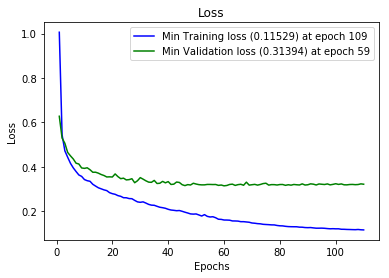

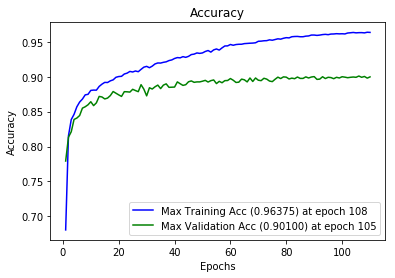

total time: 63.53756809234619


In [72]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 795010


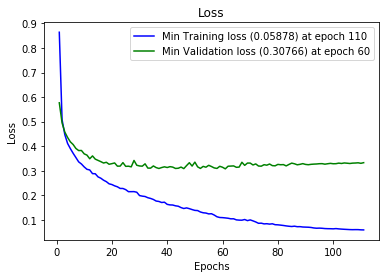

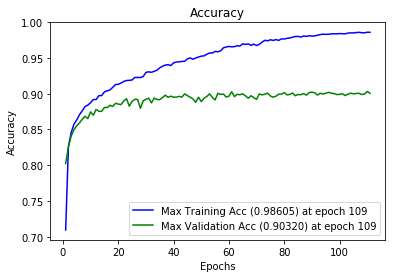

total time: 70.91481161117554


In [73]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1000, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1192510


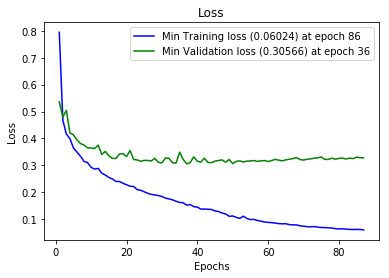

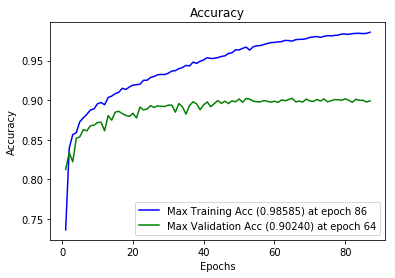

total time: 58.07013130187988


In [23]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=1500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1159510


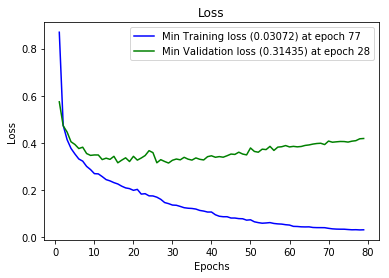

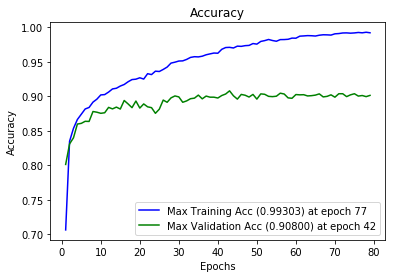

total time: 57.717485189437866


In [27]:
start = time.time()
model = create_model(hidden_layer_number=2, neurons=750, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1198210


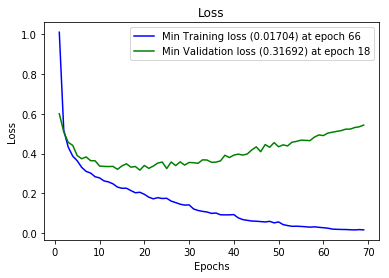

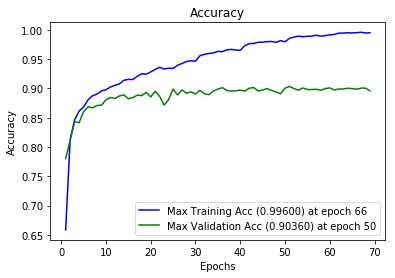

total time: 51.636571168899536


In [29]:
start = time.time()
model = create_model(hidden_layer_number=3, neurons=600, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1149010


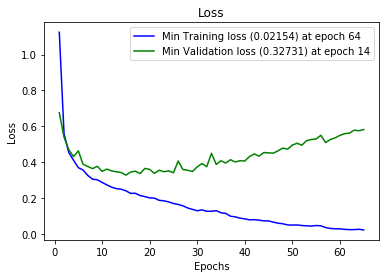

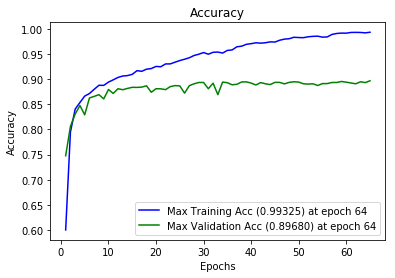

total time: 50.259227991104126


In [31]:
start = time.time()
model = create_model(hidden_layer_number=4, neurons=500, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1211935


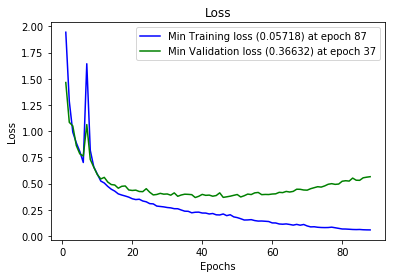

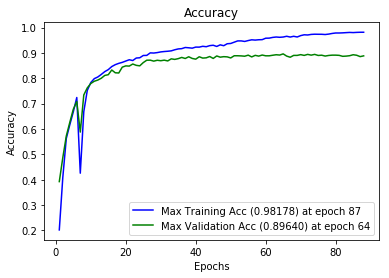

total time: 77.15779709815979


In [34]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

exploding gradient, car reseau profond sans regularisation

number of parameters: 1211935


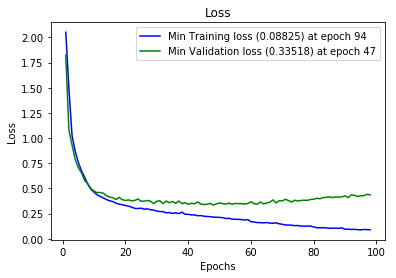

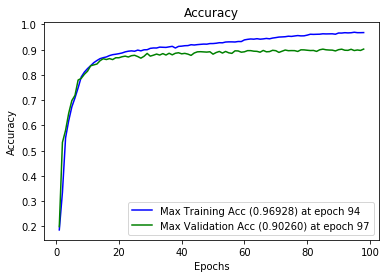

total time: 100.46095085144043


In [35]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1211935


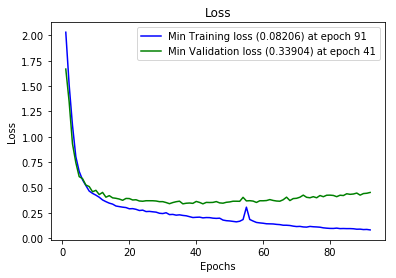

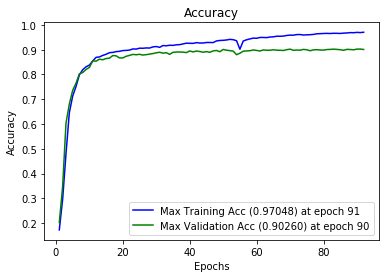

total time: 97.8376214504242


In [36]:
start = time.time()
model = create_model(hidden_layer_number=10, neurons=325, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam',l1=0.000000001,l2=0.000000001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1098690


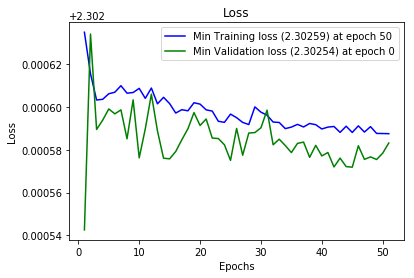

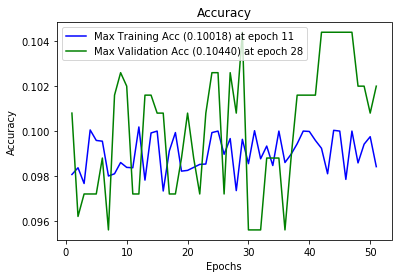

total time: 68.83352327346802


In [38]:
start = time.time()
model = create_model(hidden_layer_number=20, neurons=220, activation='relu', dropout=0.3, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

### Gradient clipping

In [39]:
from keras import optimizers

In [40]:
def create_model(hidden_layer_number=1, neurons=100, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0,l2=0):
    
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=28**2, kernel_initializer='uniform',
                    activation=activation, kernel_regularizer=l1_l2(l1,l2)))
    if dropout >0:
        model.add(Dropout(dropout)) 
    
    if batchnorm:
        model.add(BatchNormalization())

    if hidden_layer_number>1:
        for i in range(hidden_layer_number-1):
            model.add(Dense(neurons, kernel_initializer='uniform',
                            activation=activation, kernel_regularizer=l1_l2(l1,l2)))
            if dropout >0:
                model.add(Dropout(dropout))        

            if batchnorm:
                model.add(BatchNormalization())
    
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(clipnorm=1), metrics=['accuracy'])
    
    return model

number of parameters: 1098690


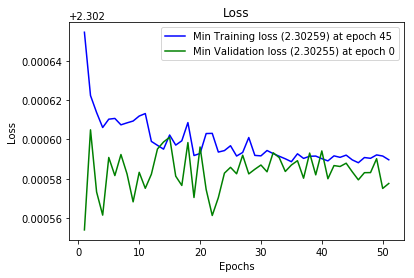

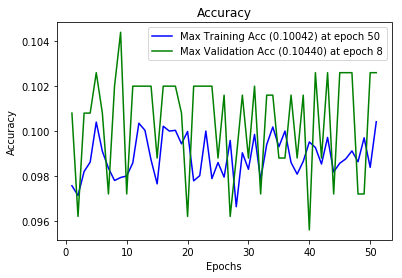

total time: 78.15977573394775


In [41]:
start = time.time()
model = create_model(hidden_layer_number=20, neurons=220, activation='relu', dropout=0.3, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

Remarque surapprentissage arrive plus rapidement si profond

quand trop profond probleme de gradient, faudrait utiliser resnet

# entenoire

In [44]:
activation='relu'
dropout=0.1
batchnorm=False
optimizer='adam'
l1=0
l2=0
model = Sequential()
model.add(Dense(1500, input_dim=28**2, kernel_initializer='uniform',
                activation=activation, kernel_regularizer=l1_l2(l1,l2)))
model.add(Dropout(dropout)) 

model.add(Dense(500, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))        

model.add(Dense(250, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))  

model.add(Dense(200, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))     

model.add(Dense(150, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))    

model.add(Dense(100, kernel_initializer='uniform', activation=activation, kernel_regularizer=l1_l2(l1,l2)))

model.add(Dropout(dropout))     


model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


number of parameters: 2149710


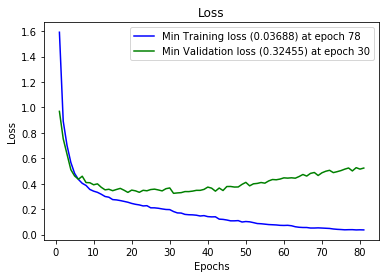

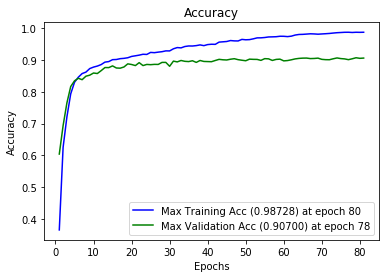

total time: 86.7406256198883


In [45]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=300, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

# Partie CNN

Dans cette section, nous essayerons differente architecture de CNN. Nous essayerons aussi des layers de types inception. ###Ici, le batch size est dimniuer a 512 peut etre changer.####

In [74]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Convolution2D
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers

In [75]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [76]:
ohe = OneHotEncoder(categories="auto",sparse=False)
ohe.fit(y_train.reshape(-1, 1))
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train = x_train.reshape(60000,28,28,1)
x_validation = x_validation.reshape(5000,28,28,1)

x_train, x_validation, x_test = x_train/255, x_validation/255, x_test/255
y_train, y_validation, y_test = ohe.transform(y_train.reshape(-1, 1)), ohe.transform(y_validation.reshape(-1, 1)), ohe.transform(y_test.reshape(-1, 1))

In [77]:
from keras.layers import InputLayer

In [78]:
from keras.layers import Flatten

In [79]:
from keras import optimizers

In [82]:
def create_model():
   
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(28,28,1)))
    
    # Normalization
    cnn.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(Flatten())

    # Fully Connected Layer
    cnn.add(Dense(256, activation='relu'))

    # Dropout
    cnn.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(BatchNormalization())

    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

    return cnn

model = create_model()

number of parameters: 493902


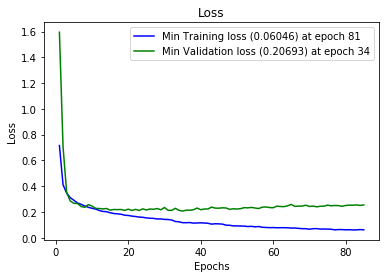

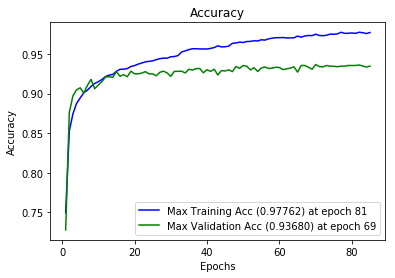

total time: 483.82999873161316


In [83]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=100, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

In [80]:
def create_model():
   
    cnn = Sequential()
    
    cnn.add(InputLayer(input_shape=(28,28,1)))
    
    # Normalization
    cnn.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(128, (4, 4), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(Convolution2D(128, (4, 4), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(Flatten())

    # Fully Connected Layer
    cnn.add(Dense(256, activation='relu'))

    # Dropout
    cnn.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(BatchNormalization())

    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

    return cnn

model = create_model()

number of parameters: 1101262


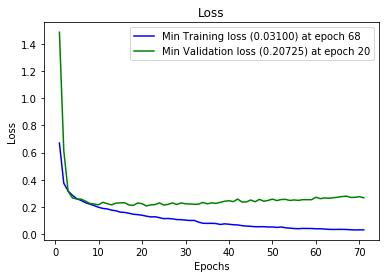

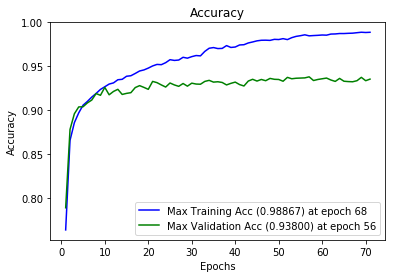

total time: 690.1002378463745


In [81]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=100, verbose=0,callbacks=callbacks)
plot_history(history)
end = time.time()
print('total time:',end-start)

In [152]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import numpy as np 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [153]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [163]:
def create_model():
    '''
    Creates a sequential model
    '''
    
    input_layer = Input(shape=(28, 28, 1))

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

    x = inception_module(x,
                         filters_1x1=384,
                         filters_3x3_reduce=192,
                         filters_3x3=384,
                         filters_5x5_reduce=48,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_1')    

    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

    x = Dropout(0.4)(x)

    x = Dense(10, activation='softmax', name='output')(x)
    model = Model(input_layer, x, name='inception_v1')
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(), metrics=['accuracy'])
    return model


model = create_model()

In [164]:
from keras.layers import MaxPool2D

number of parameters: 1091194
Train on 60000 samples, validate on 5000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.1789 - acc: 0.9334 - val_loss: 0.2726 - val_acc: 0.9026
Epoch 2/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.1813 - acc: 0.9327 - val_loss: 0.2657 - val_acc: 0.9114
Epoch 3/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.1717 - acc: 0.9362 - val_loss: 0.2526 - val_acc: 0.9134
Epoch 4/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.1698 - acc: 0.9364 - val_loss: 0.2581 - val_acc: 0.9140
Epoch 5/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.1611 - acc: 0.9408 - val_loss: 0.2619 - val_acc: 0.9126
Epoch 6/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.1588 - acc: 0.9411 - val_loss: 0.2925 - val_acc: 0.9028
Epoch 7/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.1521 - acc:

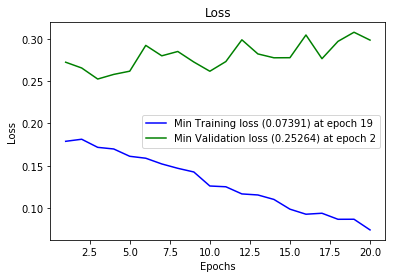

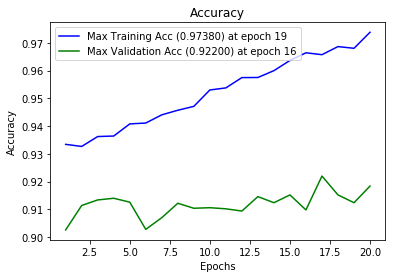

total time: 124.25318050384521


In [167]:

start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=20, verbose=0,callbacks=callbacks)

plot_history(history)
end = time.time()
print('total time:',end-start)

In [169]:
def create_model():
    '''
    Creates a sequential model
    '''
    
    input_layer = Input(shape=(28, 28, 1))

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

    x = inception_module(x,
                         filters_1x1=64,
                         filters_3x3_reduce=96,
                         filters_3x3=128,
                         filters_5x5_reduce=16,
                         filters_5x5=32,
                         filters_pool_proj=32,
                         name='inception_1')
    
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/1')(x)

    x = inception_module(x,
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=192,
                         filters_5x5_reduce=32,
                         filters_5x5=96,
                         filters_pool_proj=64,
                         name='inception_2')

    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

    x = Dropout(0.4)(x)

    x = Dense(10, activation='softmax', name='output')(x)
    model = Model(input_layer, x, name='inception_v1')
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(), metrics=['accuracy'])
    return model


model = create_model()

number of parameters: 675386
Train on 60000 samples, validate on 5000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 156us/step - loss: 0.8770 - acc: 0.6752 - val_loss: 0.5898 - val_acc: 0.7740
Epoch 2/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.4922 - acc: 0.8155 - val_loss: 0.4692 - val_acc: 0.8328
Epoch 3/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.4022 - acc: 0.8512 - val_loss: 0.4195 - val_acc: 0.8484
Epoch 4/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.3549 - acc: 0.8684 - val_loss: 0.3865 - val_acc: 0.8578
Epoch 5/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.3252 - acc: 0.8803 - val_loss: 0.3513 - val_acc: 0.8734
Epoch 6/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.3013 - acc: 0.8881 - val_loss: 0.3081 - val_acc: 0.8848
Epoch 7/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.2770 - acc: 0.89

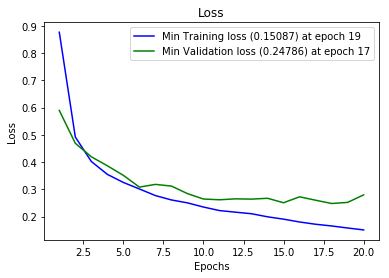

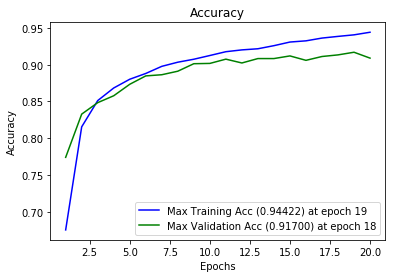

total time: 124.41415691375732


In [170]:
start = time.time()
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=512, epochs=20, verbose=0,callbacks=callbacks)

plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


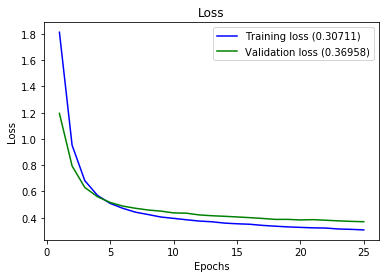

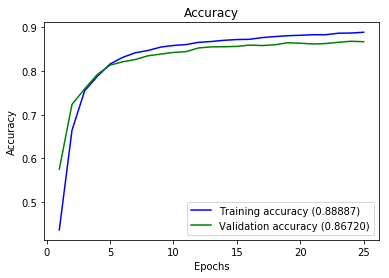

total time: 36.168643951416016


In [180]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='sigmoid', dropout=False, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=25, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

In [ ]:
#deux reseau sont mieux avec relu

number of parameters: 509410


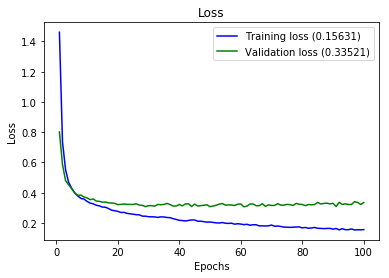

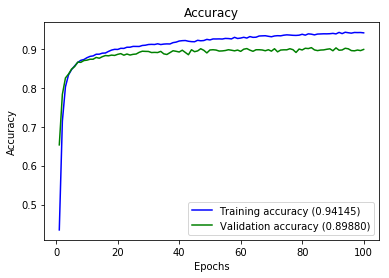

total time: 110.84814262390137


In [181]:
start = time.time()
model = create_model(hidden_layer_number=3, neurons=300, activation='relu', dropout=0.3, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


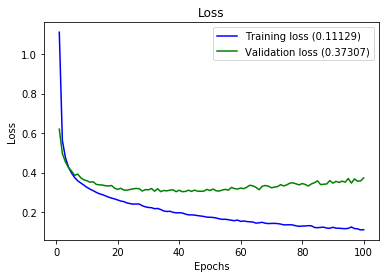

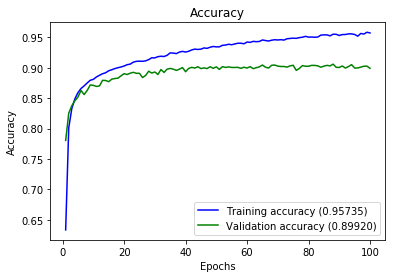

total time: 103.20390272140503


In [182]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.3, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


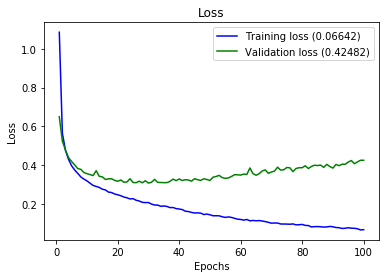

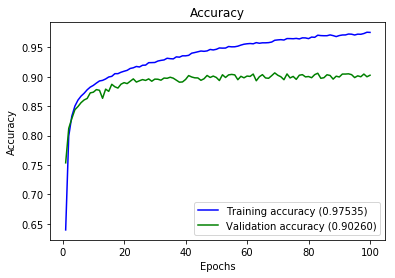

total time: 101.38467764854431


In [184]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.15, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


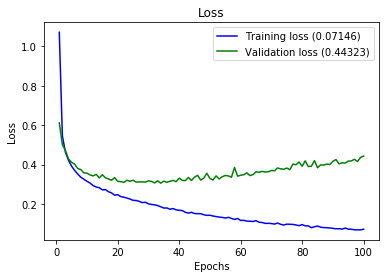

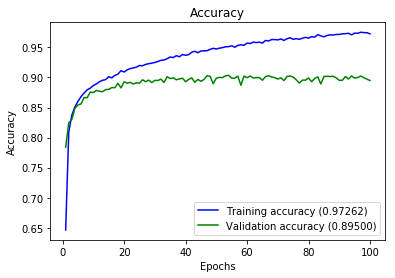

total time: 106.45170593261719


In [185]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.15, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


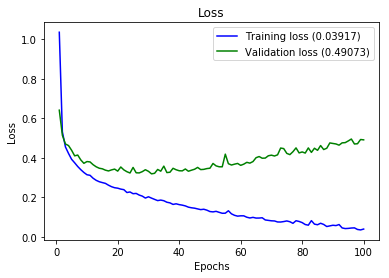

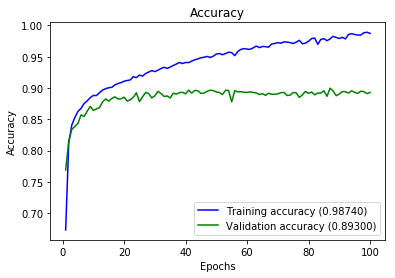

total time: 97.43385362625122


In [186]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


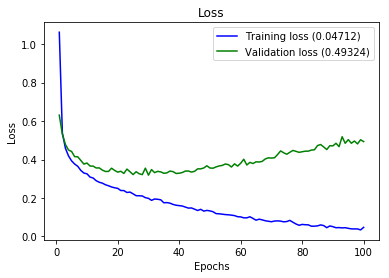

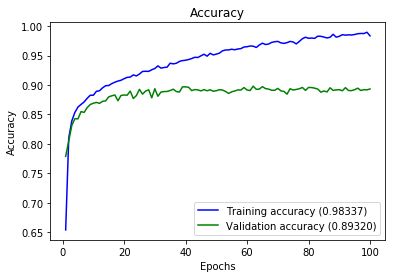

total time: 98.76486945152283


In [187]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 514090


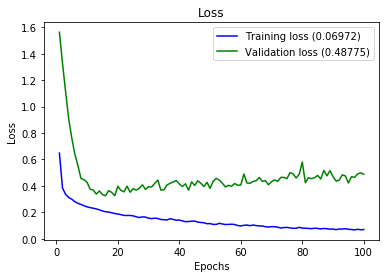

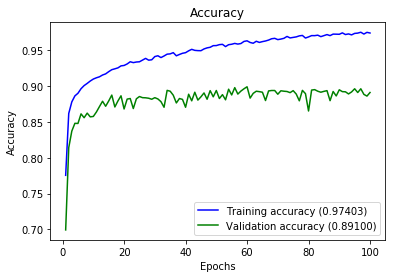

total time: 116.06040740013123


In [190]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.15, batchnorm=True, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 514090


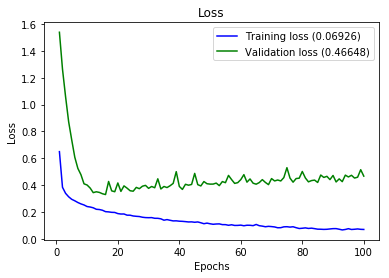

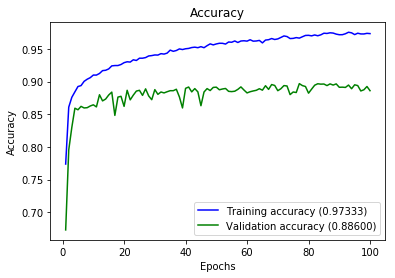

total time: 116.07996845245361


In [191]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.15, batchnorm=True, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 514090


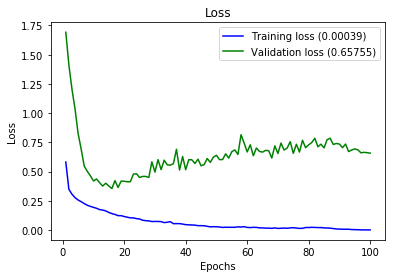

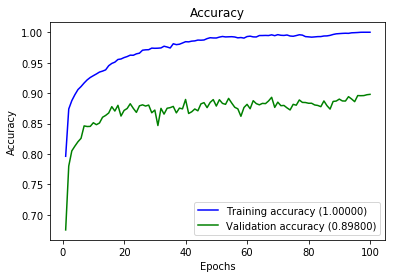

total time: 109.74357891082764


In [188]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=True, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 514090


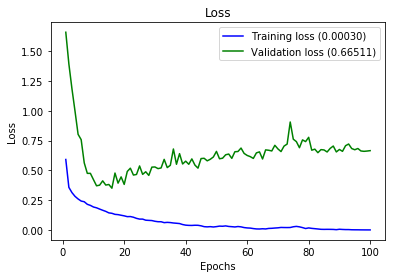

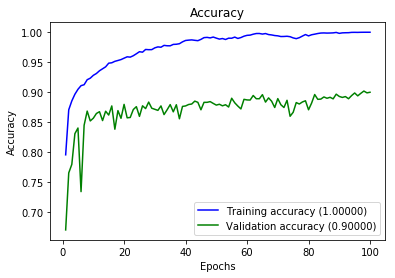

total time: 111.86219263076782


In [189]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=True, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 514090


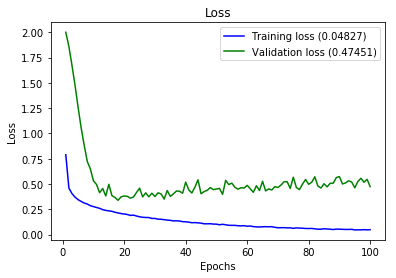

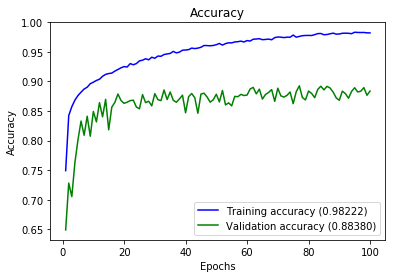

total time: 115.74169850349426


In [192]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.15, batchnorm=True, optimizer='Adadelta')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 514090


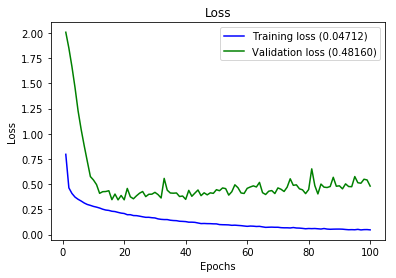

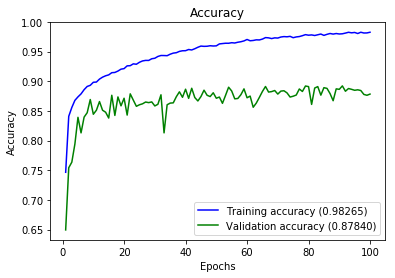

total time: 116.96321964263916


In [193]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.15, batchnorm=True, optimizer='Adadelta')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


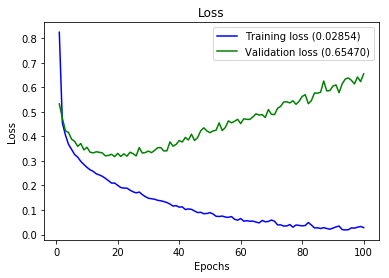

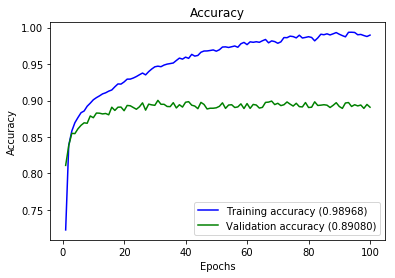

total time: 131.23572039604187


In [195]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam')
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


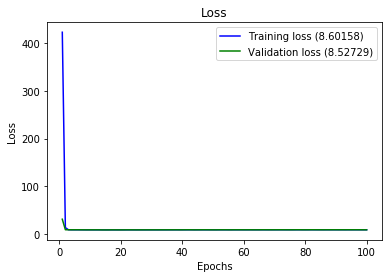

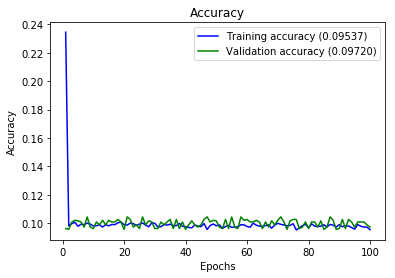

total time: 132.90981221199036


In [196]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0.1,l2=0.1)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


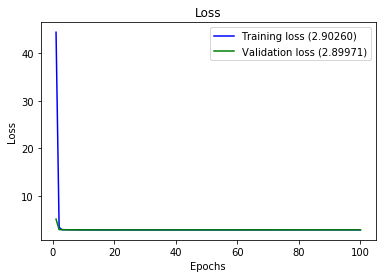

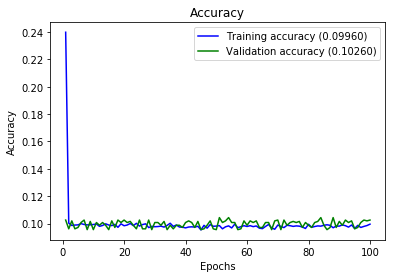

total time: 132.08411622047424


In [197]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0.01,l2=0.01)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


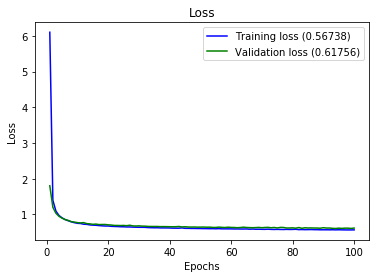

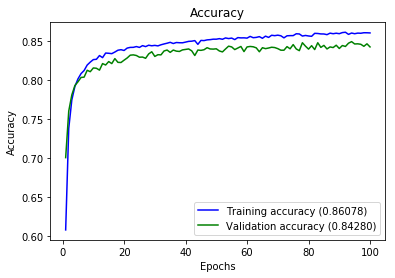

total time: 132.79804682731628


In [198]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0.001,l2=0.001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


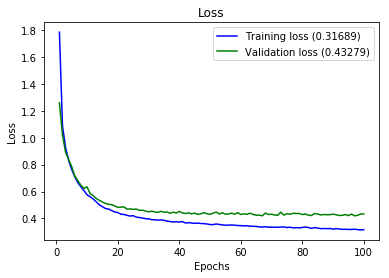

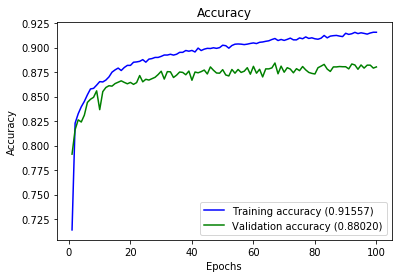

total time: 133.05763745307922


In [199]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0, batchnorm=False, optimizer='adam',l1=0.0001,l2=0.0001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1024, epochs=100, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 510730


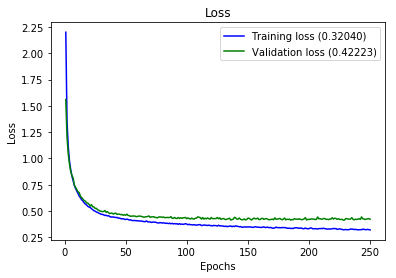

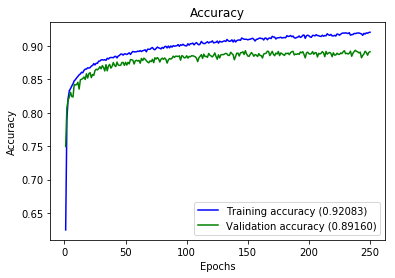

total time: 241.30653715133667


In [200]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=420, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam',l1=0.0001,l2=0.0001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=250, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 509410


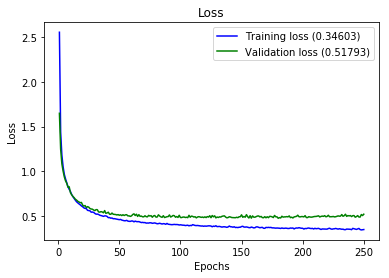

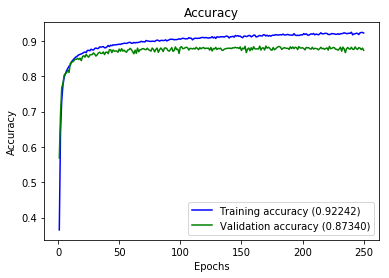

total time: 258.04925203323364


In [201]:
start = time.time()
model = create_model(hidden_layer_number=3, neurons=300, activation='relu', dropout=0.1, batchnorm=False, optimizer='adam',l1=0.0001,l2=0.0001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=250, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 1650010


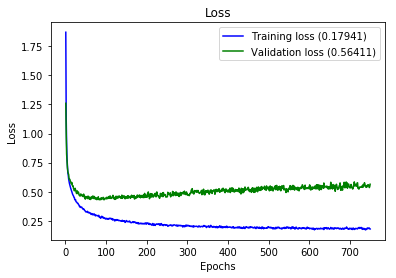

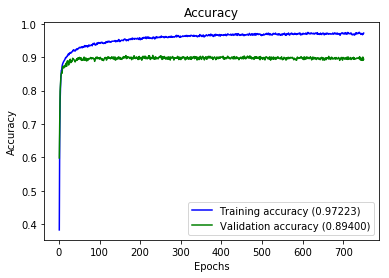

total time: 949.6500535011292


In [208]:
start = time.time()
model = create_model(hidden_layer_number=5, neurons=500, activation='relu', dropout=0.2, batchnorm=False, optimizer='adam',l1=0.00001,l2=0.00001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=750, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)

number of parameters: 89610


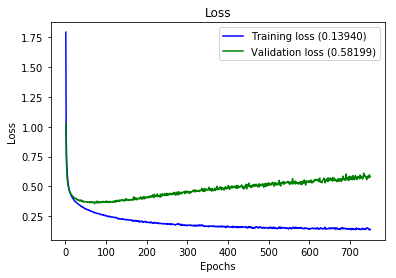

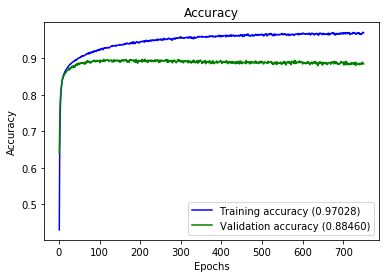

total time: 654.9598188400269


In [209]:
start = time.time()
model = create_model(hidden_layer_number=1, neurons=100, activation='relu', dropout=0.2, batchnorm=False, optimizer='adam',l1=0.00001,l2=0.00001)
print('number of parameters:',model.count_params())
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=2048, epochs=750, verbose=0)
plot_history(history)
end = time.time()
print('total time:',end-start)